## 1. 라이브러리 및 데이터 불러오기

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import missingno as msno

import warnings
warnings.filterwarnings('ignore')


# plt 테마 설정 
plt.style.use(['seaborn-white'])

plt.rc('font', family='AppleGothic')

# 맥 폰트 
plt.rcParams['axes.unicode_minus'] = False


# 데이터셋 분할 & 교차검증 & 하이퍼파라미터 튜닝 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# 결측치 처리
from sklearn.impute import SimpleImputer

# 데이터 전처리 (인코딩, 표준화, 정규화)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

# 모델링
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier




# 성능지표 
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

In [2]:
# 학습 데이터 불러오기 
train_data = pd.read_csv('/Users/dongyokim/main/jupyter/2022:2/인공지능/과제 3/train.csv')


# test용 데이터 불러오기
test_data = pd.read_csv('/Users/dongyokim/main/jupyter/2022:2/인공지능/과제 3/test.csv')

# 제출용 데이터 불러오기 
submission_data = pd.read_csv('/Users/dongyokim/main/jupyter/2022:2/인공지능/과제 3/submission_18010244_김동요.csv')

### 1) 변수 소개

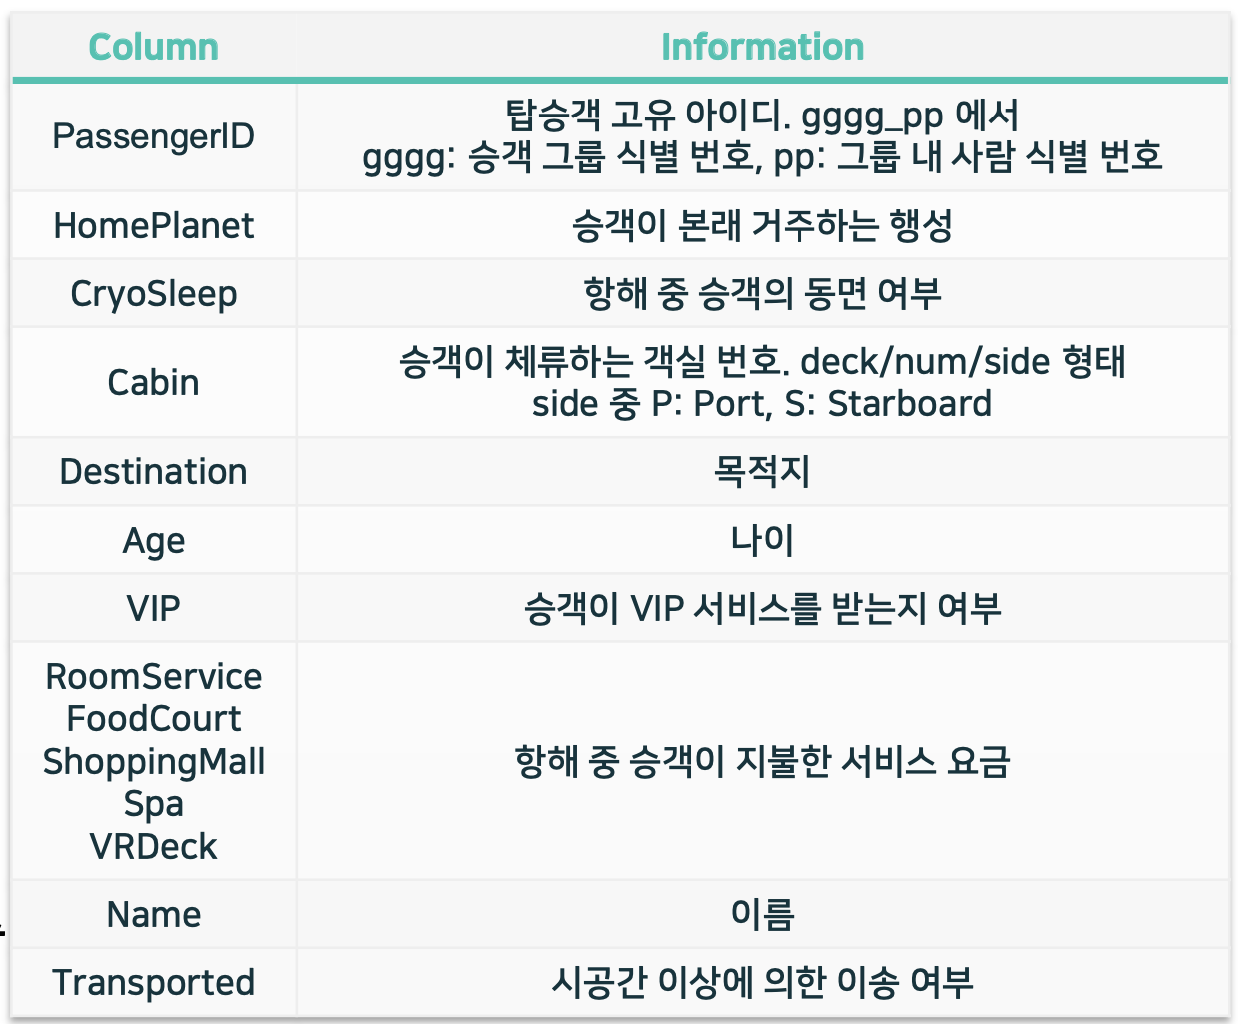

### 2) 데이터 확인

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
print('train_data shape : {}'.format(train_data.shape))
print('train_data의 결측치 : {}'.format(sum(train_data.isna().sum())))
print('test_data shape : {}'.format(test_data.shape))
print('test_data의 결측치 : {}'.format(sum(test_data.isna().sum())))

train_data shape : (8693, 14)
train_data의 결측치 : 2324
test_data shape : (4277, 13)
test_data의 결측치 : 1117


- train_data는 행이 8693개이며, test_data는 행이 4277개이다. 
- train_data의 결측값들은 총 2324개이며, test_data의 결측값들은 총 1117개이다.

In [6]:
train_data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689    False
8690    False
8691    False
8692    False
Length: 8693, dtype: bool

In [7]:
print(f'train_data 중복값: {train_data.duplicated().sum()}, ({np.round(100*train_data.duplicated().sum()/len(train_data),1)}%)')
print('')
print(f'test_data 중복값: {test_data.duplicated().sum()}, ({np.round(100*test_data.duplicated().sum()/len(test_data),1)}%)')

train_data 중복값: 0, (0.0%)

test_data 중복값: 0, (0.0%)


- train_data와 test_data 모두 중복된 key 값(인덱스)이 없다는 것을 확인하였다. 

In [8]:
# 변수명 및 변수타입 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


- train_data에는 총 14개의 변수가 존재하며, object type 변수가 7개, float type 변수가 6개, bool type 변수가 1개 존재한다.

## 2. EDA(탐색적 데이터 분석)

### 1) 기술 통계량 확인

In [9]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


- 우주선 승객들이 푸드 코드에 사용한 금액을 나타내는 변수의 분산이 매우 크게 나타난 것으로 확인되었다. 

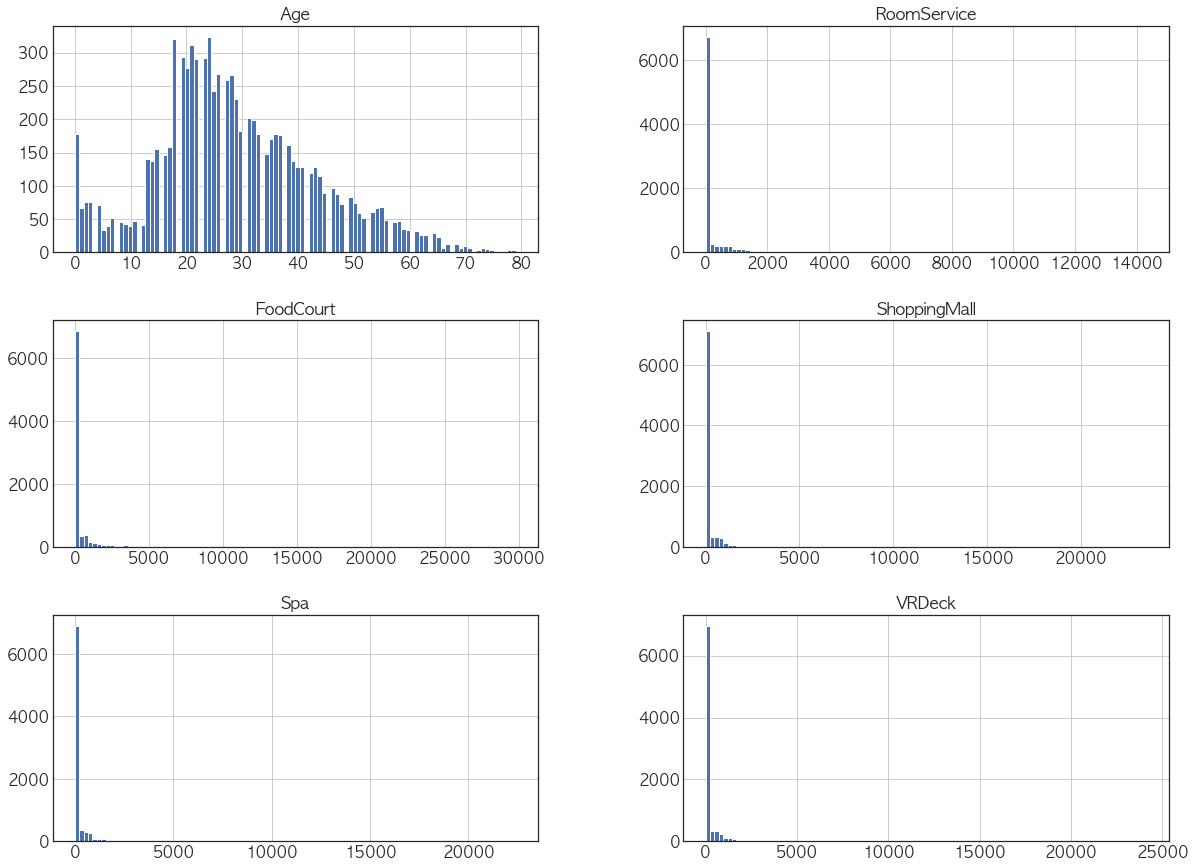

In [10]:
train_data.hist(bins = 100, figsize = (20,15))
plt.show()

- 승객들의 나이를 제외하고는 모두 분포가 한쪽으로 치우쳐 있다는 것을 확인하였으며, 승객의 연령대의 분포가 주로 20~30대에 밀집되어 있다는 것을 알 수 있다. 

### 2) 타겟 변수(Transported) 

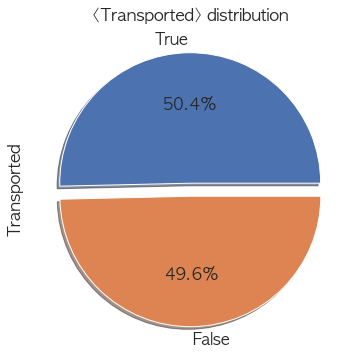

In [11]:
plt.figure(figsize=(6,6))

train_data['Transported'].value_counts().plot.pie(explode=[0.05,0.05], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("<Transported> distribution")
plt.show()

- 타겟 변수의 값이 매우 균형있게 나눠져 있는 것을 알 수 있다. -> 오버샘플링이나 언더 샘플링을 해야할 필요가 없다.

### 3) 연속형 변수

In [12]:
train_data.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


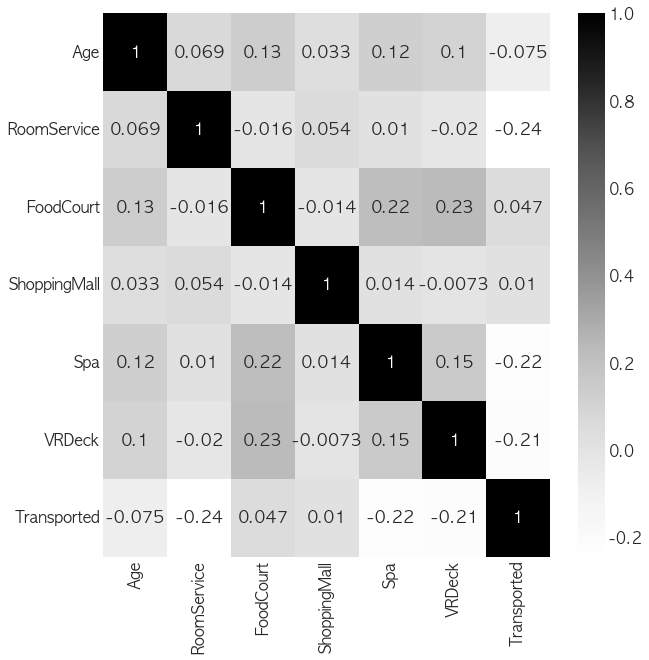

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(train_data.corr(), annot=True, cmap='Greys')
plt.show()

In [14]:
 # 상관계수 큰 순으로 나열
correlation = train_data.corr()['Transported'].abs().sort_values(ascending = False)
correlation

Transported     1.000000
RoomService     0.244611
Spa             0.221131
VRDeck          0.207075
Age             0.075026
FoodCourt       0.046566
ShoppingMall    0.010141
Name: Transported, dtype: float64

- 대체적으로 타겟 변수와의 상관계수가 낮게 나타나지만, 그 중 가장 높은 상관성을 보이는 변수로는 룸서비스에 사용한 가격을 나타내는 변수(RoomService)임을 알 수 있다. 

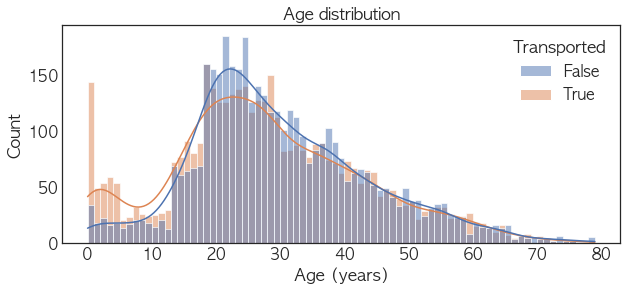

In [15]:
plt.figure(figsize=(10,4))

sns.histplot(data=train_data, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title('Age distribution')
plt.xlabel('Age (years)')

plt.show()

- 0-18세 아동은 운송되지 않을 경우보다 이송될 가능성이 매우 크게 나타났다. 
- 그에 반해, 18-25세의 연령은 이송될 가능성이 적습니다.
- 25세 이상의 연령은 이송되거나 이송되지 않을 가능성이 거의 비슷하게 나타났다.  

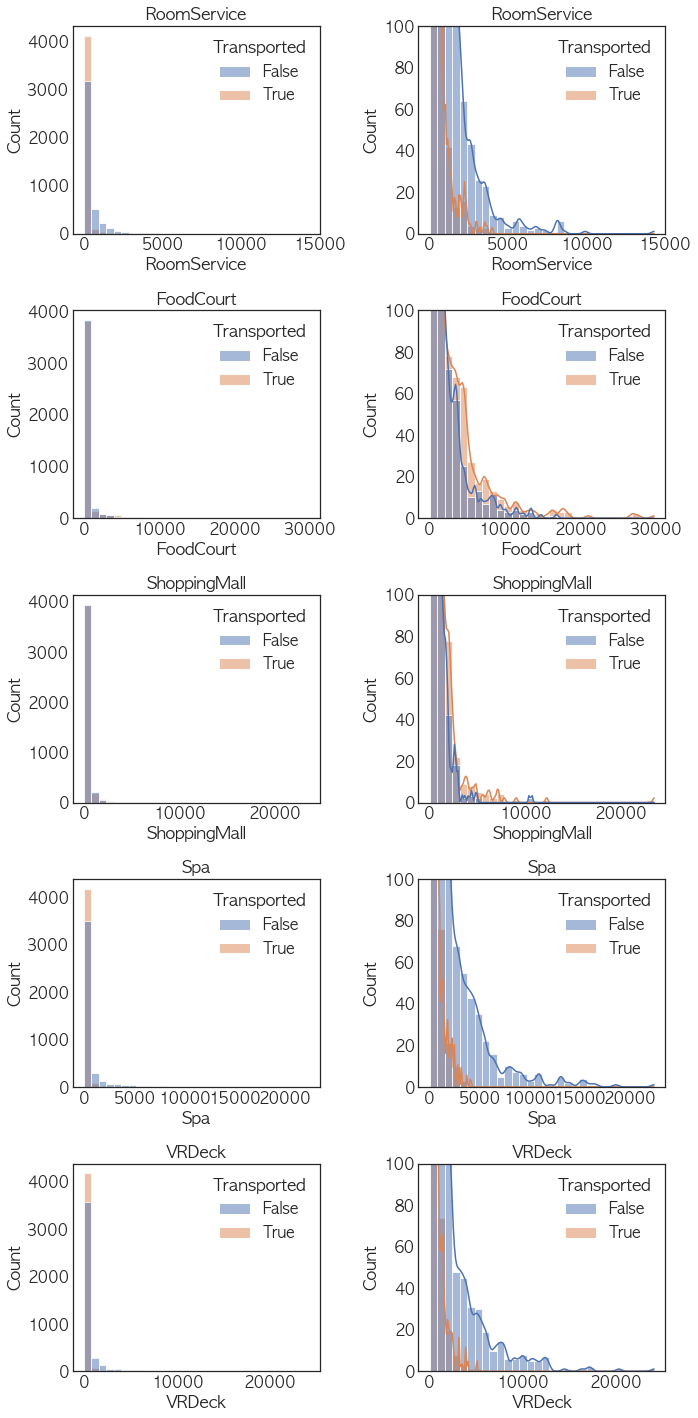

In [16]:
# 지출 변수들 
expenditure_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(expenditure_feats):

    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train_data, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    

    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_data, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout() 
plt.show()

- 대다수의 분포가 왼쪽으로 치우친 것으로 보아, 대부분의 사람들은 돈을 많이 지출하지 않는다. 
- 오른쪽의 커널 밀도 그래프(kde)를 보면, 지출 분포는 기하급수적으로 감소하는 것을 알 수 있다. 
- 또한, 소수의 이상치이 있음을 확인할 수 있다. 
- 다른 차원으로 이송된 사람들은 푸드코드와 쇼핑몰을 제외하고 더 적게 지출하는 경향이 있음을 확인할 수 있다.   
    -> 5개의 모든 편의 시설에 대한 총 지출을 나타내는 변수를 새롭게 추가해주자.  
    -> 지출 변수들을 보면, 비어있는 NaN 값이 많이 존재하는데, 특정 탑승객이 아무것도 지출하지 않았는지 여부를 나타내는 이진 변수를 추가해주자(ex 만약 5개의 소비 항목중 아무것도 지출하지 않았다면 0).  
    -> 분포를 고르게 변환하기 위해 로그 변환을 수행해주자.   


### 3) 범주형 변수

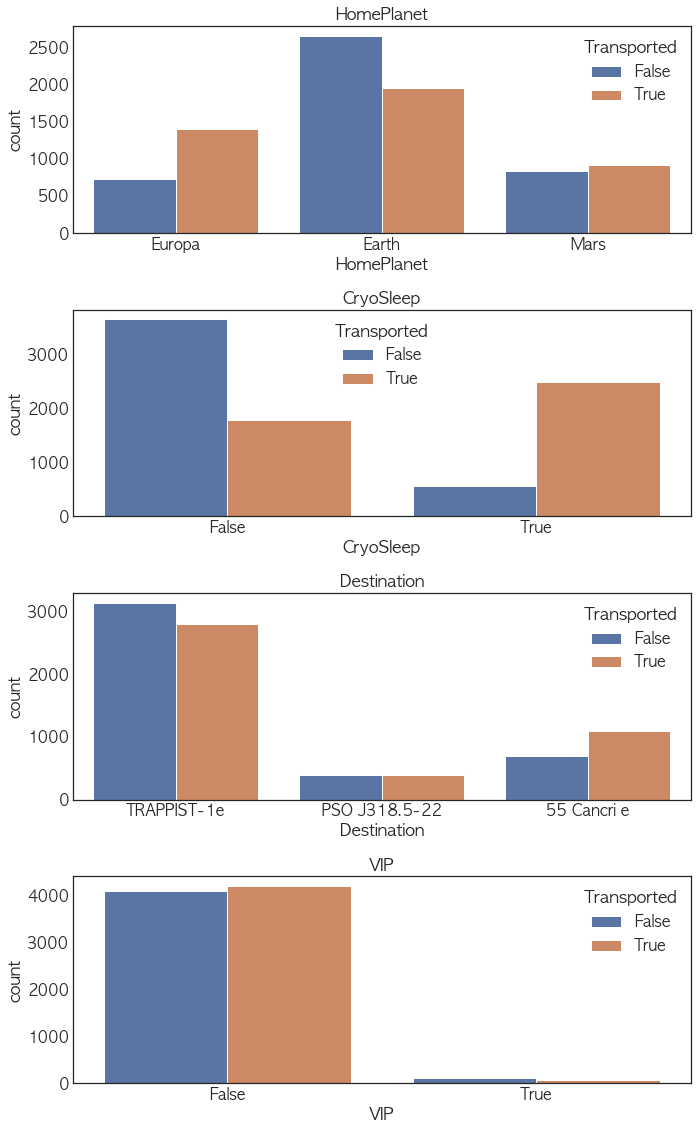

In [17]:
# 범주형 변수
categorical_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(categorical_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train_data, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout() 
plt.show()

- 향해 중 동면을 한 우주선 탑승객은 대체적으로 시공간 이상에 의해 이송되었을 경우가 매우 큰 폭으로 높으며, 동면을 하지 않았을 경우, 이송되었을 가능성이 낮아진다는 것을 알 수 있다.
- VIP 변수는 크게 target 변수에 유의하지 않을 것으로 판단된다. 

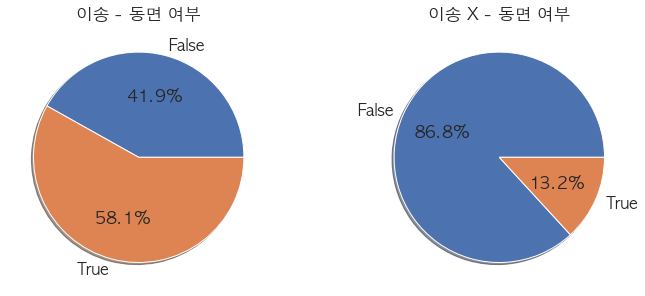

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,4), constrained_layout=True)
 
    
    
train_data[train_data['Transported'] == True]['CryoSleep'].value_counts().sort_index().plot.pie(ax=ax[0], shadow=True, autopct='%1.1f%%')
ax[0].set(ylabel='', title='이송 - 동면 여부')



#Survived 가 1인 데이터를 이용한 Pie Plot
train_data[train_data['Transported'] == False]['CryoSleep'].value_counts().sort_index().plot.pie(ax=ax[1], shadow=True, autopct='%1.1f%%')
ax[1].set(ylabel='', title='이송 X - 동면 여부')

plt.show()

### 4) 명목형 변수 

In [19]:
#명목형 변수
qualitative_feats=['PassengerId', 'Cabin' ,'Name']

train_data[qualitative_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines



## 3. 데이터 전처리 및 변수 선택

### 1) 새로운 변수 추가

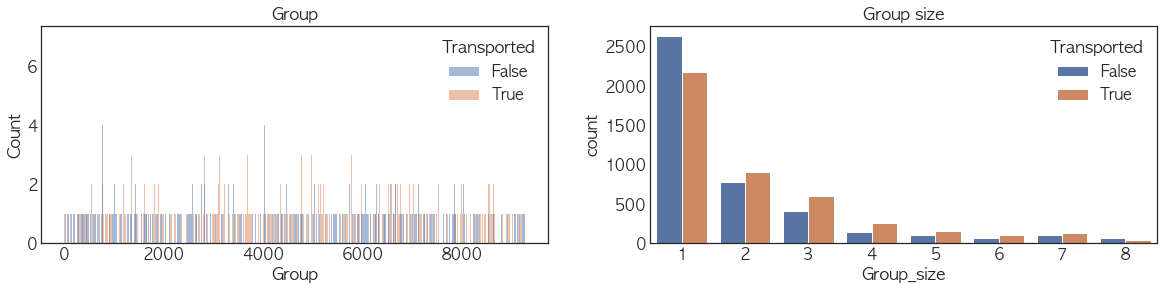

In [20]:
# 'PassengerId' 변수의 앞 4자리 수를 통해 어떤 그룹에 속해있는지 도출할 수 있다. 그래서 새로운 그룹 변수 추가해준다. 
train_data['Group'] = train_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test_data['Group'] = test_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# Group 변수를 도출하고 다시 Group 변수를 활용하여 자신의 그룹에 몇명이 속하고 있는지 나타내는 Group_size 변수 추가 
train_data['Group_size']=train_data['Group'].map(lambda x: pd.concat([train_data['Group'], test_data['Group']]).value_counts()[x])
test_data['Group_size']=test_data['Group'].map(lambda x: pd.concat([train_data['Group'], test_data['Group']]).value_counts()[x])



plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train_data, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

- 그룹 변수는 값이 너무 나도 다양하기 때문에 -> 모델에 사용할 수 없다고 판단
- 하지만 그룹 사이즈는 모델에 사용 -> 그룹에 자신이 혼자일 경우 이송되지 않을 가능성이 높음
- 솔로 여부를 나타내는 변수를 하나 더 추가해주자

(0.0, 3000.0)

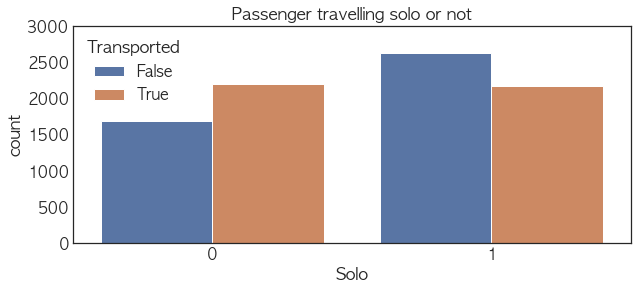

In [21]:
# 솔로 여부를 나타내는 변수 추가 
train_data['Solo']=(train_data['Group_size']==1).astype(int)
test_data['Solo']=(test_data['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train_data, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

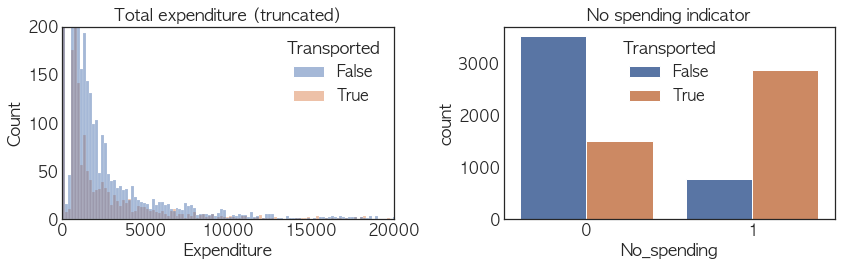

In [22]:
# EDA에서 결정한 총 지출 변수와  아무 소비를 하지 않았는지를 나타내는 지출 여부 변수 추가 
train_data['Expenditure']= train_data[expenditure_feats].sum(axis=1)
train_data['No_spending']=(train_data['Expenditure']==0).astype(int)

test_data['Expenditure']= test_data[expenditure_feats].sum(axis=1)
test_data['No_spending']=(test_data['Expenditure']==0).astype(int)

fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train_data, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()
plt.show()

- 지출을 전혀 안하는 사람이 지출을 하는 사람보다, 이송될 가능성이 높다.

Text(0.5, 1.0, 'Family size')

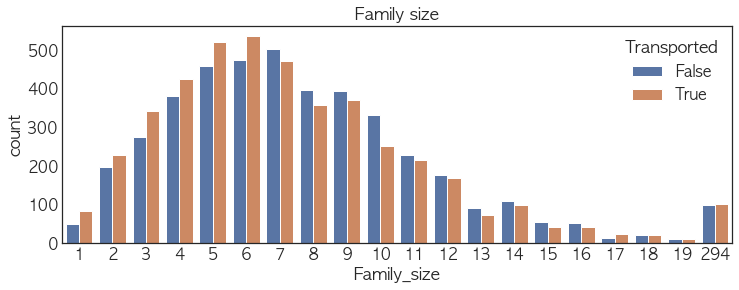

In [23]:
# 먼저 새로운 변수를 추가하기 전에 Name 변수의 결측치들을 모두 Unknown으로 채워준다.
train_data['Name'].fillna('Unknown Unknown', inplace=True)
test_data['Name'].fillna('Unknown Unknown', inplace=True)

# name 변수를 통해 성(lastname = Surname) 변수를 새롭게 추가 -> 같은 성을 기준으로 가족 수 변수 추가 
train_data['Surname']=train_data['Name'].str.split().str[-1]
test_data['Surname']=test_data['Name'].str.split().str[-1]

# 성을 기준으로 Family_size 변수 추가(가족의 수를 나타냄)
train_data['Family_size']=train_data['Surname'].map(lambda x: pd.concat([train_data['Surname'],test_data['Surname']]).value_counts()[x])
test_data['Family_size']=test_data['Surname'].map(lambda x: pd.concat([train_data['Surname'],test_data['Surname']]).value_counts()[x])

plt.figure(figsize=(12,4))
sns.countplot(data=train_data, x='Family_size', hue='Transported')
plt.title('Family size')

- Family_size가 100개이상인 값들을 일단 Nan으로 변환하고 나중에 평균 값으로 대체

In [24]:
train_data['Family_size'].value_counts()

6      1009
5       979
7       974
4       805
9       763
8       753
3       616
10      583
11      441
2       425
12      344
14      208
294     200
13      165
1       133
15       98
16       94
18       43
17       38
19       22
Name: Family_size, dtype: int64

In [25]:
train_data.loc[train_data['Family_size']>100,'Family_size']=np.nan
test_data.loc[test_data['Family_size']>100,'Family_size']=np.nan

### 2) 변수 선택 및 불필요한 변수 제거 

In [26]:
# 모델에 돌리지 않을 변수 삭제
def drop_features(df):
    df.drop(['PassengerId','Name', 'VIP', 'Cabin', 'Surname'], axis=1, inplace=True)
    return df

In [27]:
X = drop_features(train_data).drop('Transported', axis=1)
X_test = drop_features(test_data)

y = train_data['Transported']

### 3) 결측치 확인 및 처리

In [28]:
# 긱 변수당 결측치의 개수 확인
X.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
HomePlanet      201
Family_size     200
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Group             0
Group_size        0
Solo              0
Expenditure       0
No_spending       0
dtype: int64

- 대부분의 변수에 평균 180~200개의 결측 행들이 존재하며, 동면여부(CryoSleep) 변수가 가장 많은 결측값들을 갖고 있다.

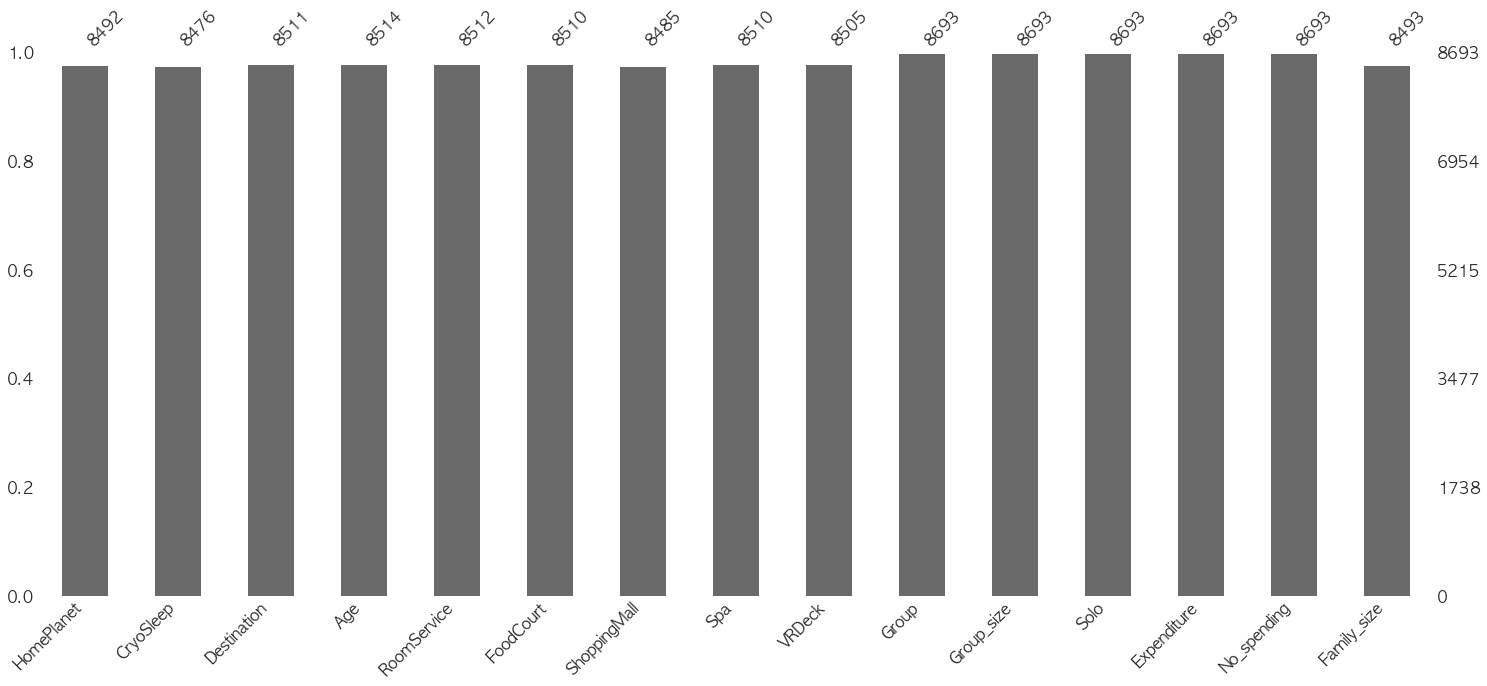

In [29]:
msno.bar(X)
plt.show()

In [30]:
# SimpleImputer 라이브러리를 사용하여 지출 변수들의 결측치는 모두 0을 넣어주었다. 
imputer_cols = ["FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='constant', fill_value=0)
imputer.fit(X[imputer_cols])
X[imputer_cols] = imputer.transform(X[imputer_cols])
X_test[imputer_cols] = imputer.transform(X_test[imputer_cols])


# age와 Family_size는 평균 값으로 넣어준다 
imputer_cols = ['Age', 'Family_size']
imputer = SimpleImputer(strategy='mean')
imputer.fit(X[imputer_cols])
X[imputer_cols] = imputer.transform(X[imputer_cols])
X_test[imputer_cols] = imputer.transform(X_test[imputer_cols])


In [31]:
# 긱 변수당 결측치의 개수 확인
X.isnull().sum().sort_values(ascending=False)

CryoSleep       217
HomePlanet      201
Destination     182
Age               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Group             0
Group_size        0
Solo              0
Expenditure       0
No_spending       0
Family_size       0
dtype: int64

In [32]:
# HomePlanet(행성 출신)의 변수를 Group과 조인해서 size(행수)를 살펴보면 각 그룹마다 출신 행성이 모두 같다는 것을 발견했다. 
gb=X.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
gb_test = X_test.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

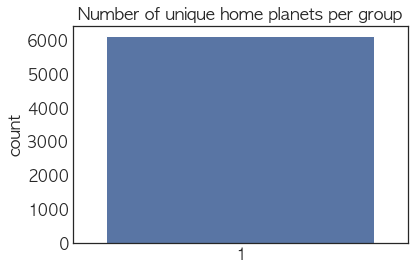

In [33]:
# Countplot of unique values
sns.countplot((gb>0).sum(axis=1))
plt.title('Number of unique home planets per group')
plt.show()

In [34]:
# 전처리 전 결측치 수 
HP_bef=X['HomePlanet'].isna().sum()

# 출신 행성 변수의 결측값을 가진 승객 및 HomePlanet이 알려진 그룹에 있는 승객
GHP_index=X[X['HomePlanet'].isna()][(X[X['HomePlanet'].isna()]['Group']).isin(gb.index)].index
GHP_index_test = X_test[X_test['HomePlanet'].isna()][(X_test[X_test['HomePlanet'].isna()]['Group']).isin(gb_test.index)].index
# 결측값을 해당 그룹이 선택한 행성으로 대체 
X.loc[GHP_index,'HomePlanet']=X.iloc[GHP_index,:]['Group'].map(lambda x: gb.idxmax(axis=1)[x])
X_test.loc[GHP_index_test,'HomePlanet']=X_test.iloc[GHP_index_test,:]['Group'].map(lambda x: gb_test.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',X['HomePlanet'].isna().sum())

#HomePlanet missing values before: 201
#HomePlanet missing values after: 111


- 그래서 출신 행성 변수의 결측치 값을 해당 그룹에서 선택한 행성명으로 변경해주면 된다.! 

#HomePlanet missing values before: 111
#HomePlanet missing values after: 0


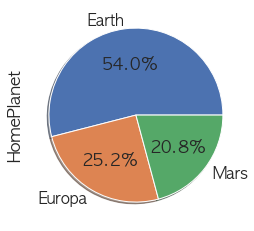

In [37]:
# 남은 결측치들은 빈도가 높은 범주형 값드로 대체 
# 승객의 대다수(54.0%)가 Earth 출신이기 때문에,해당 값으로 결측치 대체
X['HomePlanet'].value_counts().sort_index().plot.pie(shadow=True, autopct='%1.1f%%')

H_bef=X['HomePlanet'].isna().sum()

X.loc[(X['HomePlanet'].isna()), 'HomePlanet']='Earth'
X_test.loc[(X_test['HomePlanet'].isna()), 'HomePlanet']='Earth'

print('#HomePlanet missing values before:',H_bef)
print('#HomePlanet missing values after:',X['Destination'].isna().sum())

In [38]:
# 그룹 변수 삭제
X.drop('Group', axis=1, inplace=True)
X_test.drop('Group', axis=1, inplace=True)

#Destination missing values before: 182
#Destination missing values after: 0


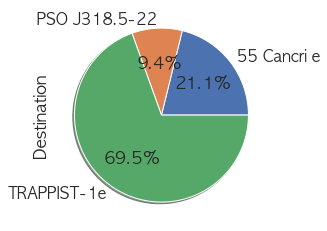

In [36]:
# 승객의 대다수(69.5%)가 TRAPPIST-1e로 향하고 있기 때문에 해당 값으로 결측치 대체
X['Destination'].value_counts().sort_index().plot.pie(shadow=True, autopct='%1.1f%%')

D_bef=X['Destination'].isna().sum()

# 'TRAPPIST-1e'를 채워줌 
X.loc[(X['Destination'].isna()), 'Destination']='TRAPPIST-1e'
X_test.loc[(X_test['Destination'].isna()), 'Destination']='TRAPPIST-1e'
# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',X['Destination'].isna().sum())

In [41]:
# CryoSleep 변수의 결측치를 처리하기 위해 결합 테이블 
X.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,4921.0,0.0
1,518.0,3037.0


- 승객이 동면을 했는지 여부를 예측하는 가장 좋은 방법은 지출한 금액이 있는지 확인하는 것이라고 생각
- 보통 동면을 한 사람들이 지출을 하지 않았다는 것을 알 수 있음 

In [54]:
# 전처리 전 결측치 개수 
CSL_bef=X['CryoSleep'].isna().sum()

# 지출을 전혀 하지 않은 승객은 동면을 한 것으로, 지출을 한 승객은 동면을 하지 않았다고 가정하여 결측치를 대체해준다. 
na_rows=X.loc[X['CryoSleep'].isna(),'CryoSleep'].index
na_rows_test=X_test.loc[X_test['CryoSleep'].isna(),'CryoSleep'].index

X.loc[X['CryoSleep'].isna(),'CryoSleep']=X.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows]
X_test.loc[X_test['CryoSleep'].isna(),'CryoSleep']=X_test.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_test]

print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',X['CryoSleep'].isna().sum())

#CryoSleep missing values before: 217
#CryoSleep missing values after: 0


In [55]:
# 긱 변수당 결측치의 개수 확인
X.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Group_size      0
Solo            0
Expenditure     0
No_spending     0
Family_size     0
dtype: int64

- 결측치 처리를 완료

### 4) 로그변환

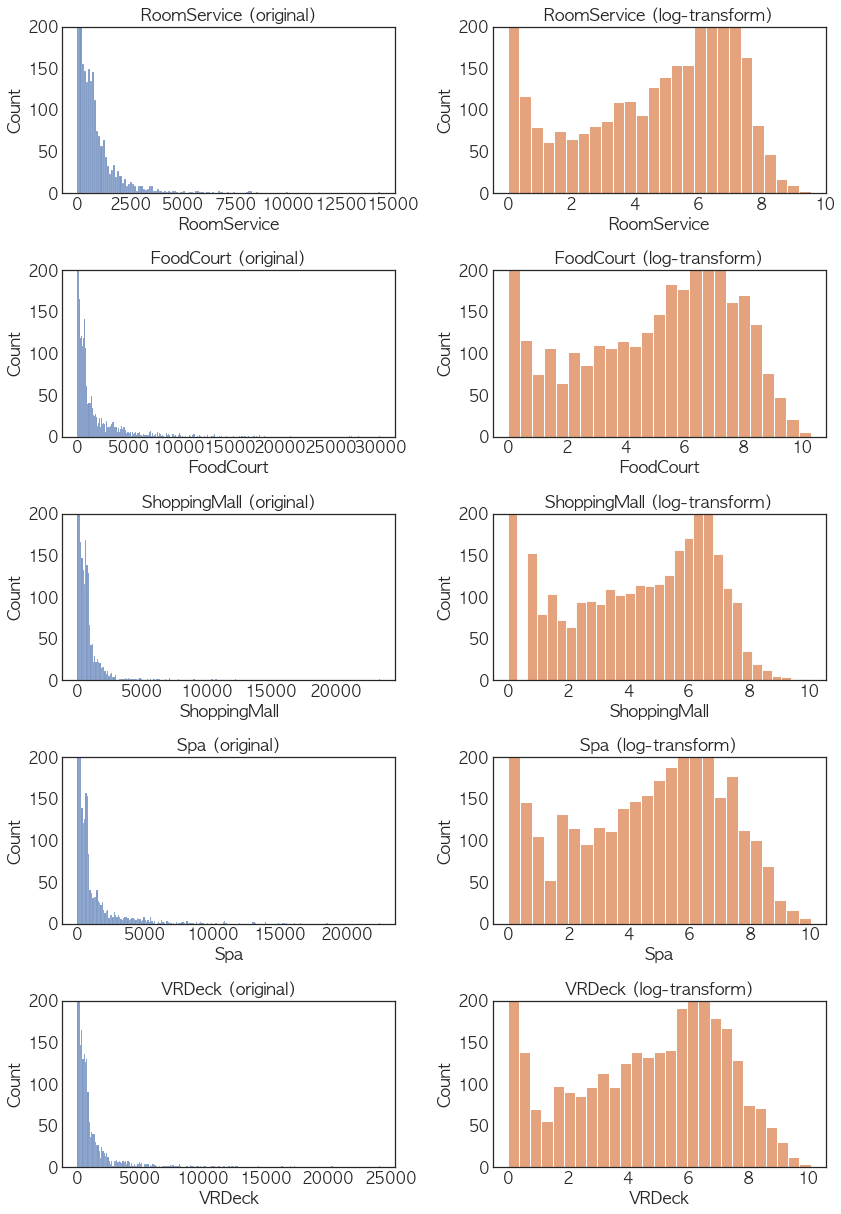

In [56]:
# 지출항목들은 한쪽으로 치우친 분포가 많아서 모두 로그변환 해준다. 
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+train_data[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()


- 로그변환을 해준다면 분포가 고르게 scaling 되는 것을 알 수 있다.

In [57]:
# 로그변환 적용
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
    X[col]=np.log1p(X[col])
    X_test[col]=np.log1p(X_test[col])

### 5) 수치형 변수 표준화 및 범주형 변수 인코딩

In [58]:
# 수치형 변수와 범주형 볌수 전처리 진행 
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# 수치형 변수 표준화 진행
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# 범주형 변수 원핫 인코딩 진행 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# 전처리한 데이터 결합 
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

X = ct.fit_transform(X)
X_test = ct.transform(X_test)

print('Training set shape:', X.shape)

Training set shape: (8693, 18)


In [59]:
# 학습 데이터 내부에서 검증 데이터 셋 생성
# 생존 여부 클래스가 0이 더 많기 때문에 균등하게 나눠주기 위해 stratify 옵션 적용
X_train, X_test_1, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=11)

In [60]:
print(X_train.shape, y_train.shape)
print(X_test_1.shape, y_test.shape)

(6954, 18) (6954,)
(1739, 18) (1739,)


---
## 4. 모델링

In [61]:
# 성능 지표 나타내주는 함수 구현 
def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    
    # f1 score print 추가 
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, auc))

In [62]:
# Roc 곡선을 나타내주는 함수
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, x, y축 명 설정 등 
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Specificity)');plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

In [63]:
# 모델과 학습/테스트 데이터 세트를 입력하면 성능, 평가 수치를 반환 
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predict_proba = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
    print('###', model.__class__.__name__, '###')
    get_clf_eval(y_test, pred, predict_proba)
    
    roc_curve_plot(y_test, predict_proba)
    print()

### 1) 모델 학습 및 평가

### DecisionTreeClassifier ###
오차행렬
[[630 233]
 [237 639]]
정확도: 0.7297, 정밀도: 0.7328, 재현율: 0.7295, F1:0.7311, AUC:0.7351


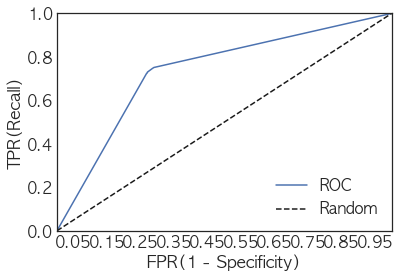


### RandomForestClassifier ###
오차행렬
[[690 173]
 [202 674]]
정확도: 0.7844, 정밀도: 0.7957, 재현율: 0.7694, F1:0.7824, AUC:0.8478


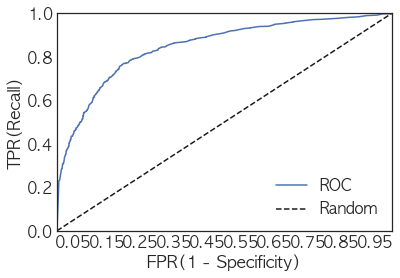


### LogisticRegression ###
오차행렬
[[646 217]
 [180 696]]
정확도: 0.7717, 정밀도: 0.7623, 재현율: 0.7945, F1:0.7781, AUC:0.8451


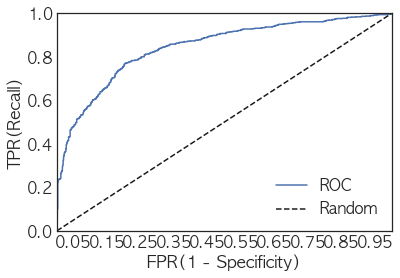


### LGBMClassifier ###
오차행렬
[[652 211]
 [151 725]]
정확도: 0.7918, 정밀도: 0.7746, 재현율: 0.8276, F1:0.8002, AUC:0.8659


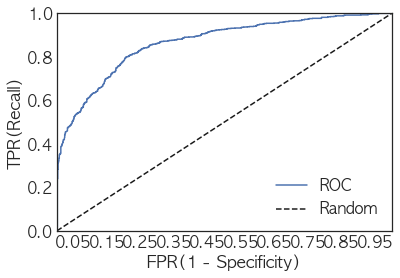

In [67]:
# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성 
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(random_state=11)
lgbm_clf = LGBMClassifier(random_state=11)

models = [dt_clf, rf_clf, lr_clf, lgbm_clf]

for model in models:
    get_model_predict(model, X_train, X_test_1, y_train, y_test)

- 대체적으로 lightgbm 모델과 랜덤포레스트 모델이 성능이 가장 높게 나타남

---
## 5. 교차 검증

In [68]:
def cross_score(model, x, y):
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=5)
    print('###', model.__class__.__name__, '###')
    for iter_count, accuracy in enumerate(scores):

        print('교차 검증 {0} 정확도: {1:.4f}'.format(iter_count, accuracy))
    print('평균 정확도: {0:.4f}'.format(np.mean(scores)))
    print()

In [69]:
for model in models:
    cross_score(model, X, y)

### DecisionTreeClassifier ###
교차 검증 0 정확도: 0.7067
교차 검증 1 정확도: 0.7073
교차 검증 2 정확도: 0.7303
교차 검증 3 정확도: 0.7181
교차 검증 4 정확도: 0.7204
평균 정확도: 0.7166

### RandomForestClassifier ###
교차 검증 0 정확도: 0.7654
교차 검증 1 정확도: 0.7723
교차 검증 2 정확도: 0.7775
교차 검증 3 정확도: 0.7739
교차 검증 4 정확도: 0.7739
평균 정확도: 0.7726

### LogisticRegression ###
교차 검증 0 정확도: 0.7642
교차 검증 1 정확도: 0.7648
교차 검증 2 정확도: 0.7660
교차 검증 3 정확도: 0.7750
교차 검증 4 정확도: 0.7785
평균 정확도: 0.7697

### LGBMClassifier ###
교차 검증 0 정확도: 0.7924
교차 검증 1 정확도: 0.7872
교차 검증 2 정확도: 0.7901
교차 검증 3 정확도: 0.8044
교차 검증 4 정확도: 0.8055
평균 정확도: 0.7959



- 교차검증 또한,  lightgbm 모델과 랜덤포레스트 모델이 성능이 가장 높게 나타났다. 

---
## 6. 하이퍼파라미터 튜닝

In [71]:
# 랜덤 포레스트 모델의 하이퍼파리미터중 가장 성능이 높게 나오는 파라미터 값 찾기

parameters = {'max_depth':[2, 3, 5, 10],
             'min_samples_split':[2, 3, 5],
             'min_samples_leaf':[1, 5, 8]}
grid_dclf = GridSearchCV(rf_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X, y)

print('GridSearchCV 최적 하이퍼 파라미터 :', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}
GridSearchCV 최고 정확도 : 0.7948


In [73]:
# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
dpredictions = best_dclf.predict(X_test_1)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8419


- 그리드 서치를 통해 랜덤포레스트 모델의 최적의 하이퍼 파라미터를 도출하였으며, 해당 모델로 검증 데이터셋에서 성능평가

In [77]:
# 그리드 서치
# light_GBM 모델의 하이퍼파리미터중 가장 성능이 높게 나오는 파라미터 값 찾기

# parameters = { "n_estimators": [100, 500, 1000],
#     "learning_rate": [0.01, 0.05, 0.1, 0.3], 
#     'num_leaves':[20,60,100],
#     'reg_alpha':[0,0.01,0.03],
#     "max_depth": [5, 10, 15, 20]}
# grid_rclf = GridSearchCV(lgbm_clf, param_grid=parameters, scoring='accuracy', cv=5)
# grid_rclf.fit(X, y)

# print('GridSearchCV 최적 하이퍼 파라미터 :', grid_rclf.best_params_)
# print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_rclf.best_score_))
# best_rclf = grid_rclf.best_estimator_

-light_gbm 모델을 그리그 서치로 돌리면 너무 많은 시간이 소요 되기 때문에 랜덤 서치로 돌려준다. 

In [81]:
# 랜덤 서치 
# light_GBM 모델의 하이퍼파리미터중 가장 성능이 높게 나오는 파라미터 값 찾기

parameters = { "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3], 
    'num_leaves':[20,60,100],
    'reg_alpha':[0,0.01,0.03],
    "max_depth": [5, 10, 15, 20]}
# 시간이 너무 오래 소요되기 떄문에, 랜덤 서치로 돌려준다.
grid_rclf = RandomizedSearchCV(lgbm_clf, param_distributions=parameters,  n_iter=50, n_jobs=-1,scoring='accuracy')
grid_rclf.fit(X, y)

print('RandomSearchCV 최적 하이퍼 파라미터 :', grid_rclf.best_params_)
print('RandomSearchCV 최고 정확도 : {0:.4f}'.format(grid_rclf.best_score_))
best_rclf = grid_rclf.best_estimator_

RandomSearchCV 최적 하이퍼 파라미터 : {'reg_alpha': 0.01, 'num_leaves': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}
RandomSearchCV 최고 정확도 : 0.7992


- RandomSearch를 통해 light_gbm 모델의 최적의 하이퍼 파라미터 도출 

In [82]:
# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
dpredictions = best_rclf.predict(X_test_1)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8079


- 성능이 랜덤포레스트보다 light_gbm 모델이 높게 나와, 최종적으로 light_gbm 모델을 채택 

---
## 6. 테스트 데이터 예측값 제출

In [83]:
pred =best_rclf.predict(X_test)

In [84]:
submission_data['Transported'] = pred

In [85]:
submission_data

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [88]:
# csv 추출 
submission_data.to_csv('submission_18010244_김동요.csv', index=False)